<a href="https://colab.research.google.com/github/Mikky-sout/ImageProcessingOnly/blob/main/ModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Mask detection

In [2]:
import tensorflow.keras.applications.mobilenet_v2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import keras
import glob
from keras.preprocessing import image
from keras import Model,Input
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Train data

**Prepare dataset**

In [3]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

Load image

In [34]:
data = []
labels = []

DIRECTORY = r"/content/drive/MyDrive/dataset"
CATEGORIES = ["with_mask", "without_mask"]

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(150, 150))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [35]:
#perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [36]:
train_X, test_X, train_Y, test_Y = train_test_split(data, labels,test_size=0.30, stratify=labels, random_state=23)

**Create ImageDataGenerator**

In [37]:
datagen = ImageDataGenerator(rotation_range=45,
	                                            zoom_range=0.25,
	                                            width_shift_range=0.2,
	                                            height_shift_range=0.2,
	                                            shear_range=0.15,
	                                            horizontal_flip=True,
	                                            fill_mode="nearest")

**Create Model**

In [38]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

In [129]:
#Create MobileNet
base_model = MobileNet(weights ='imagenet',include_top=False,input_tensor=Input(shape=(150, 150, 3)))

#append additional layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(512,activation='relu')(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(2,activation='softmax')(x)

#define input and output layers
model = Model(inputs = base_model.input,outputs=preds)
model.summary()

#define trainable layer
for layer in base_model.layers:
	layer.trainable = False

Model: "model_155"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_156 (InputLayer)      [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                                  

**Create Optimizer , parameters**

In [132]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [135]:
EP = 30
BS = 64
training_Model = model.fit(datagen.flow(train_X, train_Y, batch_size=BS),
	steps_per_epoch=len(train_X) // BS,
	validation_data=(test_X, test_Y),
	validation_steps=len(test_X) // BS,
	epochs=EP)

Epoch 1/30
41/41 [==============================] - 18s 440ms/step - loss: 0.1516 - accuracy: 0.9381 - val_loss: 0.0220 - val_accuracy: 0.9930
Epoch 2/30
41/41 [==============================] - 18s 435ms/step - loss: 0.0830 - accuracy: 0.9710 - val_loss: 0.0250 - val_accuracy: 0.9904
Epoch 3/30
41/41 [==============================] - 16s 386ms/step - loss: 0.0684 - accuracy: 0.9771 - val_loss: 0.0162 - val_accuracy: 0.9939
Epoch 4/30
41/41 [==============================] - 17s 421ms/step - loss: 0.0435 - accuracy: 0.9851 - val_loss: 0.0111 - val_accuracy: 0.9957
Epoch 5/30
41/41 [==============================] - 16s 385ms/step - loss: 0.0582 - accuracy: 0.9832 - val_loss: 0.0134 - val_accuracy: 0.9939
Epoch 6/30
41/41 [==============================] - 16s 387ms/step - loss: 0.0449 - accuracy: 0.9859 - val_loss: 0.0157 - val_accuracy: 0.9948
Epoch 7/30
41/41 [==============================] - 16s 393ms/step - loss: 0.0467 - accuracy: 0.9855 - val_loss: 0.0133 - val_accuracy: 0.9948

# Predict and Plotting result

In [204]:
from sklearn.metrics import accuracy_score

In [205]:
pred = model.predict(test_X, batch_size=BS)
y_true = test_Y
pred_max = np.argmax(pred, axis=1)
y_true = np.argmax(y_true, axis=1)
y_train = np.argmax(train_Y, axis=1) 

In [206]:
print("Test accuracy:", accuracy_score(y_true, pred_max))

Test accuracy: 0.9965217391304347


In [207]:
print('--------- Confusion matrix-----------')
print(confusion_matrix(test_Y.argmax(axis=1), pred_max))
print('--------- Classification Report matrix -----------')
print(classification_report(test_Y.argmax(axis=1), pred_max,
	target_names=lb.classes_))

--------- Confusion matrix-----------
[[574   1]
 [  3 572]]
--------- Classification Report matrix -----------
              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       575
without_mask       1.00      0.99      1.00       575

    accuracy                           1.00      1150
   macro avg       1.00      1.00      1.00      1150
weighted avg       1.00      1.00      1.00      1150



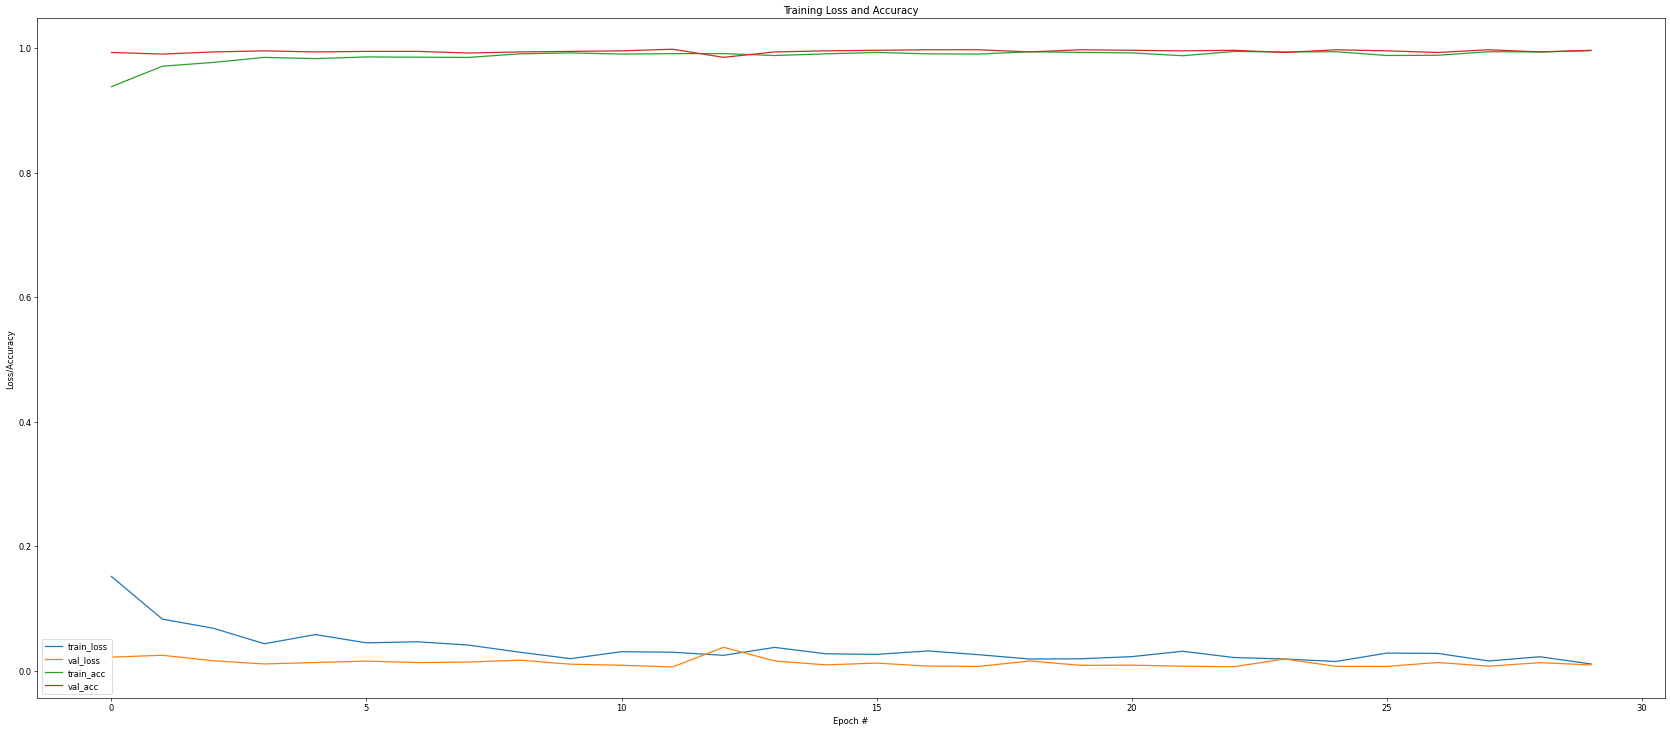

In [208]:
N = EP
plt.figure(figsize=(35, 15), dpi=60)
plt.plot(np.arange(0, N), training_Model.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), training_Model.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), training_Model.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), training_Model.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

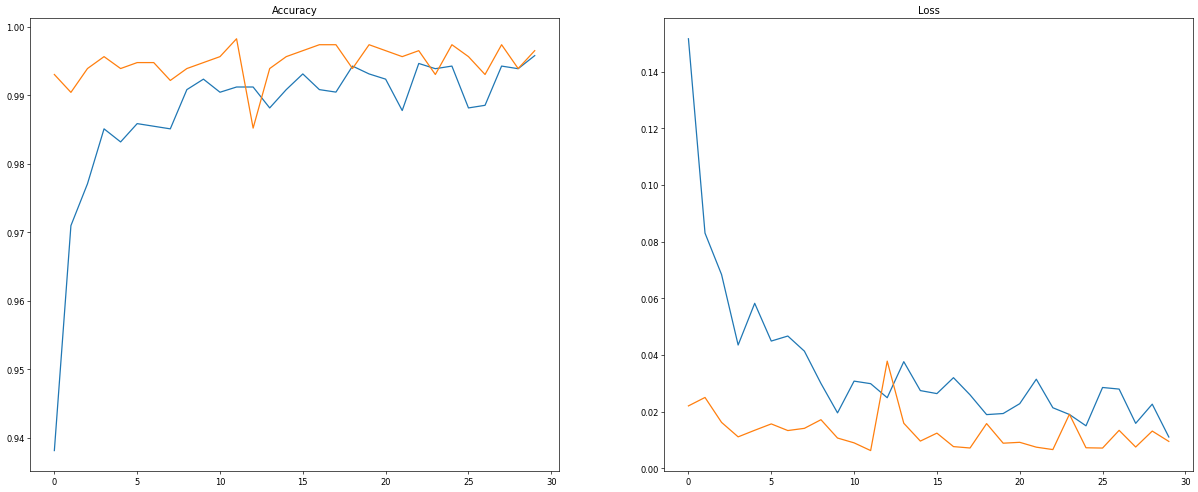

In [209]:
plt.figure(figsize=(25, 10), dpi=60)
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(training_Model.history["accuracy"], label="Train_acc")
plt.plot(training_Model.history["val_accuracy"], label="Validate_acc")
plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(training_Model.history['loss'], label="Train_loss")
plt.plot(training_Model.history['val_loss'], label="Validate_loss")

# Save Model

In [210]:
model.save("/content/drive/MyDrive/Project.model", save_format="h5")

# Application section

# GridSearch (Hyperparameter)

In [117]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [118]:
def create_model(optimizer='adam'):
  base_model = MobileNet(weights ='imagenet',include_top=False,input_tensor=Input(shape=(150, 150, 3)))

  #append additional layer
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Flatten(name="flatten")(x)
  x = Dense(512,activation='relu')(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.5)(x)
  preds = Dense(2,activation='softmax')(x)

  #define input and output layers
  model = Model(inputs = base_model.input,outputs=preds)

  #define trainable layer
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [123]:
model_gs = KerasClassifier(build_fn=create_model,verbose=1)
EPList = [10,20,30]
BSList = [16,32,64]
OPlist = ['Adam']
param_grid = dict(optimizer=OPlist,epochs=EPList,batch_size=BSList)
grid = GridSearchCV(estimator=model_gs, param_grid=param_grid,  cv=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [124]:
grid_result = grid.fit(train_X, train_Y)

Epoch 1/10
84/84 [==============================] - 4s 24ms/step - loss: 0.1429 - accuracy: 0.9575
Epoch 2/10
84/84 [==============================] - 2s 23ms/step - loss: 0.0283 - accuracy: 0.9918
Epoch 3/10
84/84 [==============================] - 2s 23ms/step - loss: 0.0519 - accuracy: 0.9873
Epoch 4/10
84/84 [==============================] - 2s 23ms/step - loss: 0.0247 - accuracy: 0.9940
Epoch 5/10
84/84 [==============================] - 2s 23ms/step - loss: 0.0159 - accuracy: 0.9955
Epoch 6/10
84/84 [==============================] - 2s 23ms/step - loss: 0.0183 - accuracy: 0.9940
Epoch 7/10
84/84 [==============================] - 2s 23ms/step - loss: 0.0058 - accuracy: 0.9970
Epoch 8/10
84/84 [==============================] - 2s 23ms/step - loss: 0.0101 - accuracy: 0.9970
Epoch 9/10
84/84 [==============================] - 2s 23ms/step - loss: 0.0035 - accuracy: 0.9993
Epoch 10/10
84/84 [==============================] - 3s 23ms/step - loss: 0.0382 - accuracy: 0.9948
Epoch 1/1

In [125]:
print('Best params: ',grid_result.best_params_)
print('Best params: ',grid_result.best_score_)

Best params:  {'batch_size': 64, 'epochs': 30, 'optimizer': 'Adam'}
Best params:  0.9936633706092834


In [126]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

In [127]:
data = pd.DataFrame()
data['params'] = params
data['means'] = means
data['stds'] = stds

data

,params,means,stds
0,"{'batch_size': 16, 'epochs': 10, 'optimizer': ...",0.992918,0.001866
1,"{'batch_size': 16, 'epochs': 20, 'optimizer': ...",0.992546,0.000003
2,"{'batch_size': 16, 'epochs': 30, 'optimizer': ...",0.992546,0.000003
3,"{'batch_size': 32, 'epochs': 10, 'optimizer': ...",0.991428,0.000370
4,"{'batch_size': 32, 'epochs': 20, 'optimizer': ...",0.989189,0.006340
5,"{'batch_size': 32, 'epochs': 30, 'optimizer': ...",0.992545,0.001494
6,"{'batch_size': 64, 'epochs': 10, 'optimizer': ...",0.991055,0.000742
7,"{'batch_size': 64, 'epochs': 20, 'optimizer': ...",0.991800,0.000742
8,"{'batch_size': 64, 'epochs': 30, 'optimizer': ...",0.993663,0.001121


# KFold

In [99]:
from sklearn import model_selection
from keras.wrappers.scikit_learn import KerasClassifier

In [115]:
Num_fold = 3
Seed = 23
model_kf = KerasClassifier(build_fn=create_model, epochs=10, batch_size=64, verbose=1)
kfold = model_selection.KFold(n_splits=Num_fold,shuffle = True,random_state = Seed)
score = model_selection.cross_val_score(model_kf,train_X,train_Y,cv=kfold)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
28/28 [==============================] - 4s 72ms/step - loss: 0.2495 - accuracy: 0.9262
Epoch 2/10
28/28 [==============================] - 2s 71ms/step - loss: 0.0432 - accuracy: 0.9860
Epoch 3/10
28/28 [==============================] - 2s 71ms/step - loss: 0.0313 - accuracy: 0.9911
Epoch 4/10
28/28 [==============================] - 2s 70ms/step - loss: 0.0129 - accuracy: 0.9950
Epoch 5/10
28/28 [==============================] - 2s 71ms/step - loss: 0.0101 - accuracy: 0.9989
Epoch 6/10
28/28 [==============================] - 2s 73ms/step - loss: 0.0078 - accuracy: 0.9978
Epoch 7/10
28/28 [==============================] - 2s 72ms/step - loss: 0.0048 - accuracy: 0.9994
Epoch 8/10
28/28 [==============================] - 2s 71ms/step - loss: 0.0037 - accuracy: 0.9994
Epoch 9/10
28/28 [==============================] - 2s 71ms/step - loss: 0.0025 - accuracy: 0.9994
Epoch 10/10
14/14 [==============================] - 2s 70ms/step - loss: 0.0031 - accuracy: 0.9978
Epoch 1/1

In [116]:
print(score.mean())
print(score)

0.9932894309361776
[0.99776536 0.98993289 0.99217004]
